# Распознавание позы человека

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

Введем обозначение `keypoint` - это часть тела важная для определения позы человека. Ниже определим ярлыки с названием каждого `keypoint`.

In [13]:
KEYPOINTS_QUANTITY = 17 
MAX_PERSON_QUANTITY = 6
UNTRUSTABLE_KEYPOINT_THRESHOLD = 256 * 0.3
UNTRUSTABLE_PERSON_THRESHOLD = 256 * 0.3

keypoint_labels = ["nose", "left eye", "right eye", "left ear", "right ear", 
                   "left shoulder", "right shoulder", "left elbow", "right elbow", 
                   "left wrist", "right wrist", "left hip", "right hip", "left knee", 
                   "right knee", "left ankle", "right ankle"]

Загружаем предобученную модель `MOVENET` из локальной папки. Данная модель разработана компанией `Google` на основе фреймворка `Tensorflow`. На вход модель ожидает получить RGB изображение одного человека.

In [14]:
model = hub.load("movenet")
movenet = model.signatures['serving_default']

Загрузим изображение из локальной папки и подготовим его для передачи входным параметром модели.

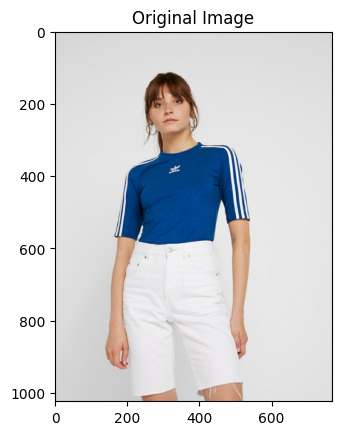

In [15]:
image_path = '00030_00.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.int32)

plt.title('Original Image')
plt.imshow(image)

Получим предсказание для подготовленного ранее изображения. В качестве результата получим представление размера [1, 6, 56]. Расшифруем измерения:
- первое измерение равно количеству batch, для данной модели всегда равно 1, наличие данного измерения обоснованно особенностями Tensorflow.
- второе измерение равно максимальному количеству людей, которых модель может распознать на изображении. 
- третье измерение представляет собой боксы/точки, описывающие части тела человека, и их оценку достоверности.

In [16]:
movenet_result = movenet(X)['output_0'].numpy()
movenet_result.shape
predictions = movenet_result[0]

Так как мы знаем, что на изображении один человек, то нужно отобрать данные, достоверность, которых наибольшая. Последнее число в строке это достоверность всего предсказания.

In [17]:
most_accurate_index = predictions[:,55].argmax()
most_accurate_row = predictions[most_accurate_index,:]
most_accurate_row = (most_accurate_row * 256).astype(float)

В строке первое 51 значение связано с keypoint-ами, остальные 5 связаны с предсказанием в целом. Подготовим словарь, где для каждого keypoint будет указаны координаты и точность предсказания.

In [18]:
keypoints_dict = {}
for i in range(KEYPOINTS_QUANTITY):
    keypoints_dict[keypoint_labels[i]] = {"x":          most_accurate_row[i * 3],
                                          "y":          most_accurate_row[i * 3 + 1],
                                          "confidence": most_accurate_row[i + 2]}
keypoints_dict

{'nose': {'x': 53.68281936645508,
  'y': 110.08720397949219,
  'confidence': 205.25962829589844},
 'left eye': {'x': 48.38102340698242,
  'y': 116.32070922851562,
  'confidence': 48.38102340698242},
 'right eye': {'x': 49.89620590209961,
  'y': 103.71116638183594,
  'confidence': 116.32070922851562},
 'left ear': {'x': 55.47563934326172,
  'y': 126.15805053710938,
  'confidence': 159.2165069580078},
 'right ear': {'x': 59.88667678833008,
  'y': 98.42314910888672,
  'confidence': 49.89620590209961},
 'left shoulder': {'x': 85.4734878540039,
  'y': 148.44142150878906,
  'confidence': 103.71116638183594},
 'right shoulder': {'x': 98.4299087524414,
  'y': 87.98719787597656,
  'confidence': 196.37786865234375},
 'left elbow': {'x': 144.43655395507812,
  'y': 159.6914825439453,
  'confidence': 55.47563934326172},
 'right elbow': {'x': 154.67832946777344,
  'y': 79.3277359008789,
  'confidence': 126.15805053710938},
 'left wrist': {'x': 195.7560577392578,
  'y': 157.1504364013672,
  'confiden

В качестве визуализации будем отрисовывать три изображение: исходное, позу и позу наложенную на исходное

In [19]:
connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee')
    ]

def draw_image(img):
    plt.subplot(1, 3, 1)
    plt.title('Person only')
    plt.axis('off')
    plt.imshow(img)

def draw_pose_only(img, keypoints_dict):
    plt.title('Pose only')
    plt.axis('off')
    plt.imshow((img / 255) / 255)
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key]
            end_point = keypoints_dict[end_key]
            plt.plot([start_point["y"], end_point["y"]], [start_point["x"], end_point["x"]], linewidth=2)
            
def draw_pose_and_image(img, keypoints_dict, keypoint_labels):
    plt.title('Pose and person')
    plt.axis('off')
    plt.imshow(img)

    for i in range(KEYPOINTS_QUANTITY):
        if keypoints_dict[keypoint_labels[i]]["confidence"] > UNTRUSTABLE_KEYPOINT_THRESHOLD:
            plt.scatter(keypoints_dict[keypoint_labels[i]]["y"], 
                        keypoints_dict[keypoint_labels[i]]["x"],color='green')

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key]
            end_point = keypoints_dict[end_key]
            plt.plot([start_point["y"], end_point["y"]], [start_point["x"], end_point["x"]], linewidth=2)

def visualize(img, keypoints_dict, keypoint_labels):
    plt.figure(figsize=(15, 5))
    draw_image(img)

    plt.subplot(1, 3, 3)
    draw_pose_and_image(img, keypoints_dict, keypoint_labels)

    plt.subplot(1, 3, 2)
    draw_pose_only(img, keypoints_dict)

Провизуализируем результаты предсказания на тестовом изображении

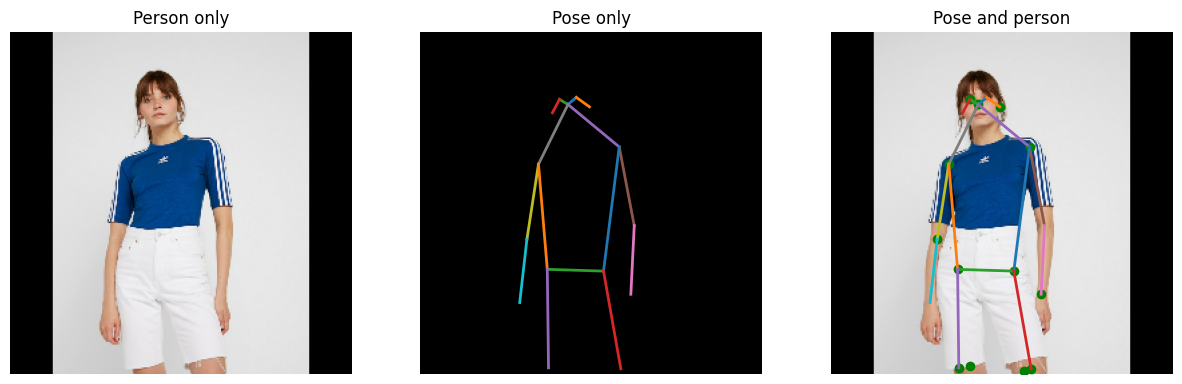

In [20]:
img = tf.image.resize_with_pad(image, 256, 256)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()[0]

visualize(img, keypoints_dict, keypoint_labels)

Получим предсказание для другой картинки, на которой будет несколько человек

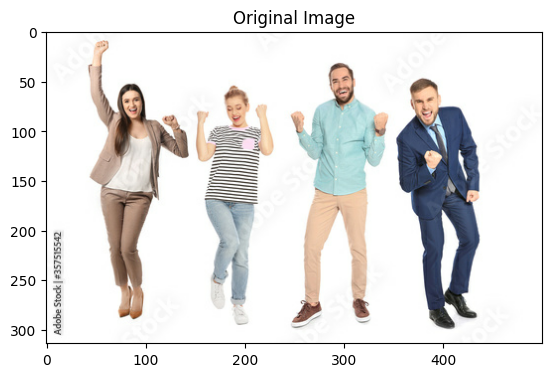

In [21]:
image_path = 'several_people.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.int32)

plt.title('Original Image')
plt.imshow(image)

movenet_result = movenet(X)['output_0'].numpy()
movenet_result.shape
predictions = movenet_result[0]

Провизуализируем предсказание

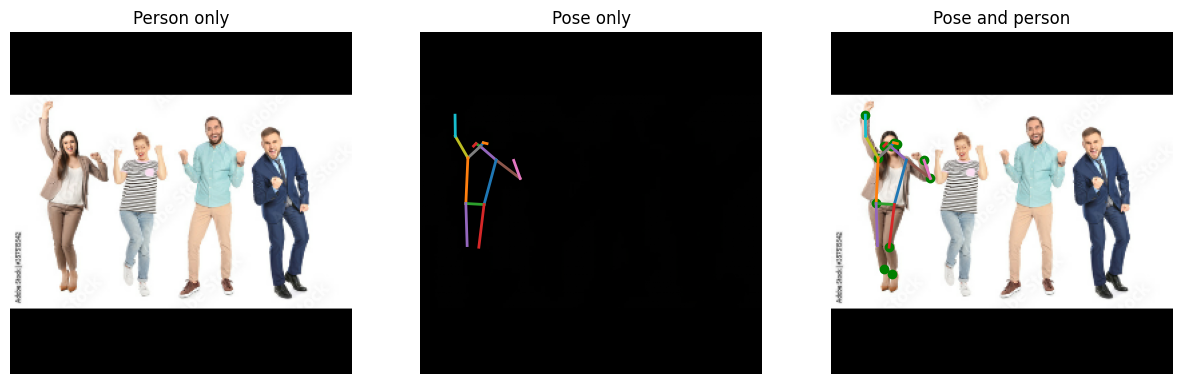

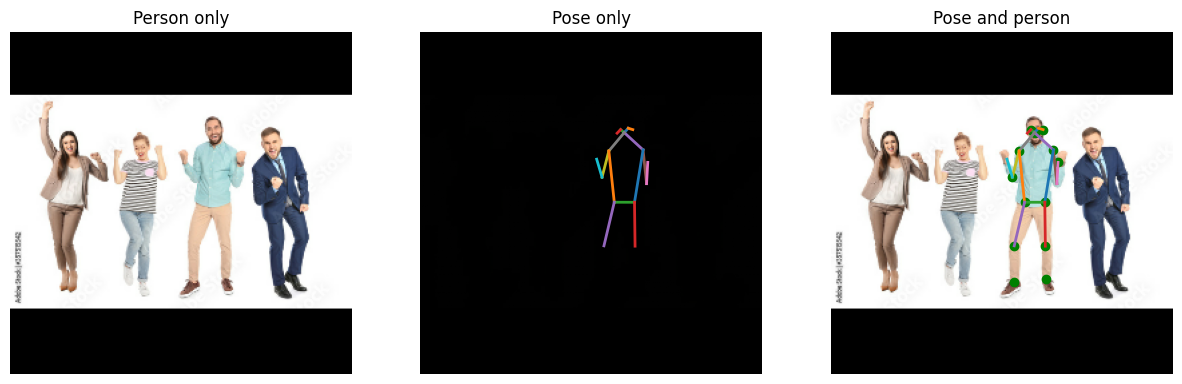

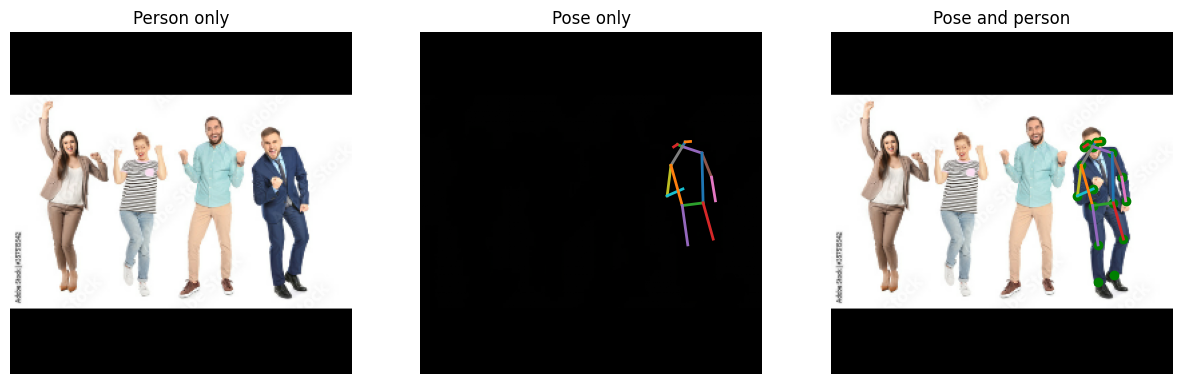

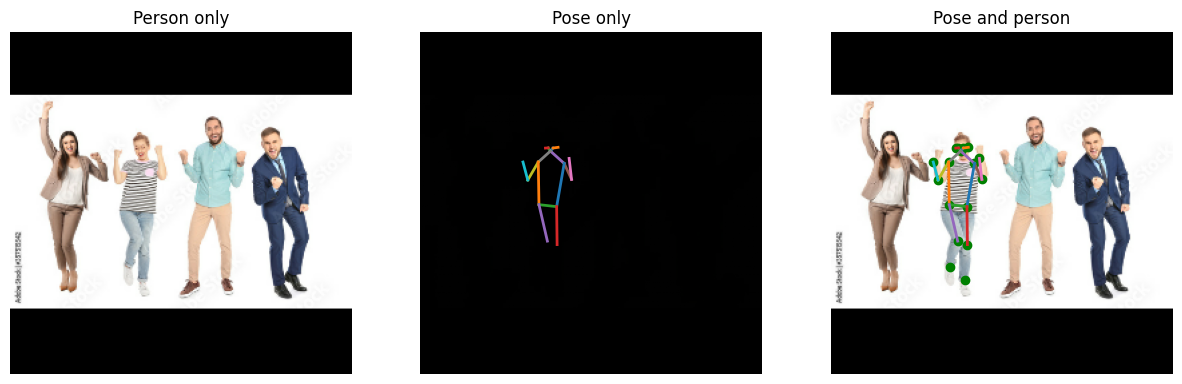

In [22]:
img = tf.image.resize_with_pad(image, 256, 256)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()[0]
for i in range(MAX_PERSON_QUANTITY):
    row = (predictions[i, :] * 256).astype(float)
    if row[55] <= UNTRUSTABLE_PERSON_THRESHOLD:
        continue

    keypoints_dict = {}
    for i in range(KEYPOINTS_QUANTITY):
        keypoints_dict[keypoint_labels[i]] = {"x": row[i * 3], "y": row[i * 3 + 1], "confidence": row[i + 2]}

    visualize(img, keypoints_dict, keypoint_labels)